In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

# import the MNIST dataset
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [2]:
# use the ball dataset
from utils import create_gaussian_dataset, add_spatial_encoding

dataset = create_gaussian_dataset(r_min=3.0, r_max=3.0, n_samples=10000, size=28, margin=1, n_balls=1)
dataset = add_spatial_encoding(dataset)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [3]:
# load the MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/opt/homebrew/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [86]:
# load the moving MNIST resized dataset 
data = np.load('data/MOVING_MNIST/mnist_test_seq_resized.npy')
data = data.reshape(-1, 1, 28, 28)
data = data.astype(np.float32)
data = (data - data.min()) / (data.max() - data.min())

train_data, test_data = train_test_split(data, test_size=0.3)

train_data = [(x,0) for x in train_data]
test_data = [(x,0) for x in test_data]

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [94]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    print(x.max())
    print(x.min())
    break

torch.Size([64, 3, 28, 28])
torch.Size([64, 2])
tensor(1., dtype=torch.float64)
tensor(0., dtype=torch.float64)


In [103]:
dec_in_channels = 1
n_latent = 96

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = int(49 * dec_in_channels / 2)
print(inputs_decoder)

24


In [104]:
class encoder(nn.Module):
    def __init__(self, keep_prob):
        super(encoder, self).__init__()
        activation = nn.LeakyReLU(0.3)
        self.encoder_model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            activation,
            nn.Dropout(keep_prob),
            nn.Conv2d(64, 64, 4, 2, 1),
            activation,
            nn.Dropout(keep_prob),
            nn.Conv2d(64, 64, 4, 2, 1),
            activation,
            nn.Dropout(keep_prob),
            nn.Flatten(),
        )
        self.mean = nn.Linear(576, n_latent)
        self.sd = nn.Linear(576, n_latent)

    def forward(self, X_in):
        latent = self.encoder_model(X_in)
        mn = self.mean(latent)
        sd = self.sd(latent)*0.5
        epsilon = torch.randn(mn.shape)
        z = mn + epsilon * torch.exp(sd)
        return z, mn, sd

class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(n_latent, inputs_decoder),
            nn.LeakyReLU(0.3),
            nn.Linear(inputs_decoder, inputs_decoder * 2 + 1),
            nn.LeakyReLU(0.3))
        self.decoder_model = nn.Sequential(
            nn.ConvTranspose2d(1, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, 1, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.last_linear = nn.Sequential(
            nn.Linear(3*28*28, 3*28*28),
            nn.Sigmoid()
        )
    def forward(self, sampled_z):
        decoded = self.linear(sampled_z)
        # print(decoded.shape)
        decoded = decoded.view(-1, 1, 7, 7)
        # print(decoded.shape)
        img = self.decoder_model(decoded)
        # print("out decoder", img.shape)
        img = self.last_linear(img)
        # print(img.shape)
        img = img.view(-1, 3, 28, 28)
        return img


class VAE(nn.Module):
    def __init__(self, keep_prob):
        super(VAE, self).__init__()
        self.encoder = encoder(keep_prob)
        self.decoder = decoder()

    def forward(self, X_in):
        z, mn, sd = self.encoder(X_in)
        img = self.decoder(z)
        return img, mn, sd

    def fit(self, dataloader_train, dataloader_test, optimizer, scheduler, criterion, epochs=10, display_step=1, n_plot=10):
        iterator = trange(epochs)
        losses_train = []
        losses_test = []
        for _ in iterator:
            self.plot(n_samples=n_plot)
            self.reconstruction(dataloader_test)
            
            loss_epoch = 0
            self.train()
            for i, data in enumerate(dataloader_train):
                input_image, _ = data
                input_image = input_image.float()
                optimizer.zero_grad()
                img, mn, sd = self(input_image)
                loss = criterion(input_image, img, mn, sd)
                loss.backward()
                optimizer.step()
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
                

            losses_train.append(loss_epoch/len(dataloader_train))
            self.eval()
            with torch.no_grad():
                loss_epoch = 0
                for i, data in enumerate(dataloader_test):
                    input_image, _ = data
                    input_image = input_image.float()
                    img, mn, sd = self(input_image)
                    loss = criterion(input_image, img, mn, sd)
                    loss_epoch += loss.item()
                    if i % display_step == 0:
                        iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')

                losses_test.append(loss_epoch/len(dataloader_test))
            
            scheduler.step()

        return losses_train, losses_test

    def generate(self, n_samples=1):
        self.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, n_latent)
            img = self.decoder(z)
            return img

    def plot(self, n_samples=1):
        self.eval()
        imgs = self.generate(n_samples)
        imgs = imgs[:,0].cpu().detach().numpy()
        imgs = np.reshape(imgs, (n_samples, 28, 28))
        fig, ax = plt.subplots(figsize=(10,5))
        for i in range(n_samples):
            plt.subplot(1, n_samples, i+1)
            plt.imshow(imgs[i], cmap='gray')
            plt.axis('off')
        plt.show()

    def reconstruction(self, plot_loader):
        self.eval()
        for i, data in enumerate(plot_loader):
            input_image, _ = data
            input_image = input_image.float()
            batch_size = input_image.shape[0]
            img, _, _ = self(input_image)
            img = img[:,0].cpu().detach().numpy()
            img = np.reshape(img, (batch_size, 28, 28))
            input_image = input_image[:,0].cpu().detach().numpy()
            input_image = np.reshape(input_image, (batch_size, 28, 28))

            fig, ax = plt.subplots(figsize=(20,2))
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1)
                plt.imshow(img[i], cmap='gray')
                plt.axis('off')
                
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1+batch_size)
                plt.imshow(input_image[i], cmap='gray')
                plt.axis('off')
            plt.show()
            break
                

class custom_loss(nn.Module):
    def __init__(self):
        super(custom_loss, self).__init__()
    
    def forward(self, x, dec, mu, sd):
        unreshaped = torch.reshape(dec, [-1, 28*28])
        x = torch.reshape(x, [-1, 28*28])
        # print(unreshaped.shape)
        img_loss = torch.mean(torch.sum((unreshaped - x)**2, dim=1))
        # print(img_loss.shape)
        latent_loss = -0.5 * torch.mean(1 + 2*sd - mu**2 - torch.exp(2*sd), dim=1)
        # print(latent_loss.shape)
        loss = torch.mean(img_loss + latent_loss)
        # print(loss.shape)
        return loss

loss_fn = custom_loss()

In [159]:
vae = VAE(0.3)
# torchsummary.summary(vae.decoder.decoder_model, (1, 7, 7)
# )

In [160]:
optimizer = torch.optim.Adam(vae.parameters(), lr=8e-3)
# optimmizer = torch.optim.RMSprop(vae.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9999)

In [161]:
# vae.plot(3)

  0%|          | 0/100 [00:00<?, ?it/s]

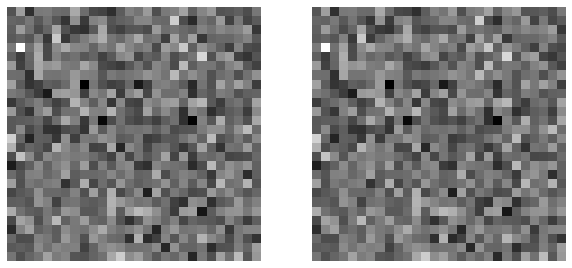

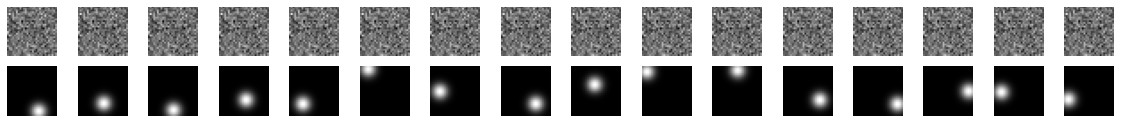

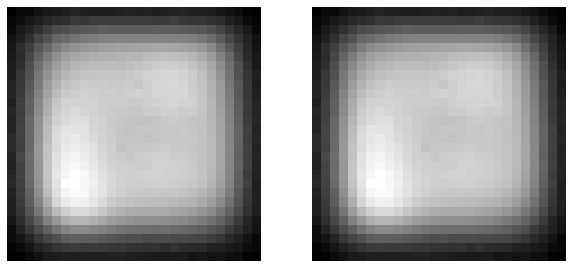

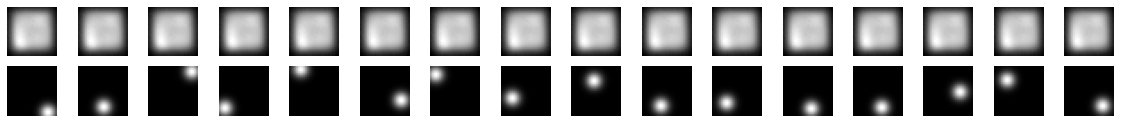

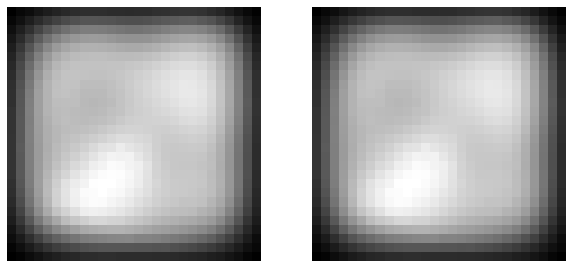

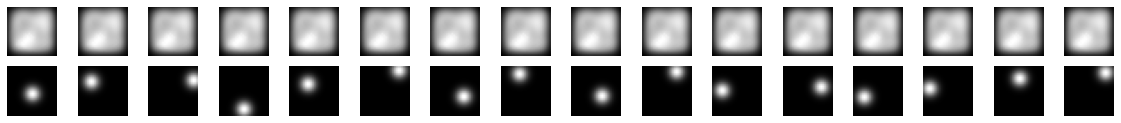

KeyboardInterrupt: 

In [162]:
# print(vae.generate(1).shape)
vae.fit(train_loader, test_loader, optimizer, scheduler, loss_fn, epochs=100, display_step=10, n_plot=2)

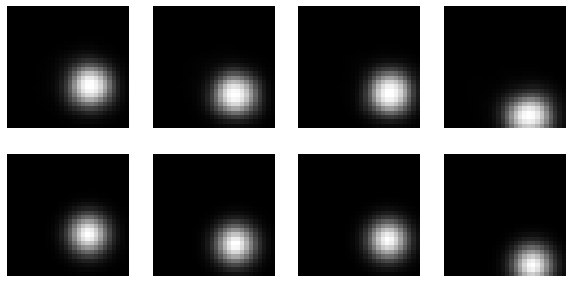

In [ ]:
# use the VAE to reconstruct images and there initial images
N_samples_recon = 4
plot_loader = DataLoader(test_dataset, batch_size=N_samples_recon)
vae.eval()
with torch.no_grad():
    for i, data in enumerate(plot_loader):
        if i <= 5:
            continue
        input_image, _ = data
        input_image = input_image.float()
        img, mn, sd = vae(input_image)
        img = img[:,0].cpu().detach().numpy()
        img = np.reshape(img, (N_samples_recon, 28, 28))
        input_image = input_image[:,0].cpu().detach().numpy()
        input_image = np.reshape(input_image, (N_samples_recon, 28, 28))

        fig, ax = plt.subplots(figsize=(10,5))
        for i in range(N_samples_recon):
            plt.subplot(2, N_samples_recon, i+1)
            plt.imshow(img[i], cmap='gray')
            plt.axis('off')
            
        for i in range(N_samples_recon):
            plt.subplot(2, N_samples_recon, i+1+N_samples_recon)
            plt.imshow(input_image[i], cmap='gray')
            plt.axis('off')
        plt.show()
        break



In [269]:
# save the model and the weights
torch.save(vae.state_dict(), 'models/VAE/vae_model_gaussian_latent_64.pth')

In [267]:
n_latent

64

In [268]:
vae.load_state_dict(
    torch.load(
    'models/VAE/vae_model_gaussian_latent_64.pth')
)

FileNotFoundError: [Errno 2] No such file or directory: 'models/VAE/vae_model_gaussian_latent_64.pth'